# Array Processing - Beamforming & Direction Finding

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.constants

from IPython.display import YouTubeVideo

Filtering is a commonly used operation in signal processing; in the discrete sense, samples are passed through a set of filter coefficients, or "taps", to perform the convolution and achieve the desired response. Analogous to such temporal filtering, an array of sensors can be filtered _spatially_ to produce a desired response across the elements.

Specifically in the context of Radio Frequency (RF) antenna arrays, this spatial filtering can be utilized to optimize the overall antenna pattern, in a process commonly known as beamforming. The specific spatial optimization is often application dependent, however beamforming is generally seen as a method of beam steering, where gain is provided in a specific, desired direction- relative to the array's front-, with attenuation in other angles. Though the term "beamforming" sounds specific to transmitting applications- like radiating RF arrays-, beamforming, and consequently spatial filtering, can actually be performed on both the transmit and receive functions of any array, also known as array reciprocity. Beamforming is inclusive of non-RF arrays and applications as well, such as sound transducers used in SONAR arrays.

The fundamental operation of beamforming is derived from the properties of constructive and destructive interference of propagating waves in phased array systems. These systems are so named in that the individual array elements shift the phase of a received, or transmitted, signal to create a desired far field array pattern that culminates into a steered wavefront.

This phase shifting process can be achieved by digital or analog means; analog phase shifter units can perform the beam steering in the RF/analog domain. In this case, each phase shifter unit is attached to an individual array antenna element, and is manifolded to a single receiver- such as an Analog to Digital Converter (ADC)- and/or a single transmitter- such as a Digital to Analog Converter (DAC). The benefits of such a system is simplicity in the digital and RF electronics, as there is only one ADC and/or DAC- and possibly one mixing/heterodyne system for the array-, however the system is much less flexible in that it can only steer in one direction at a time.

However for Multiple-Input Multiple-Output (MIMO) or other systems that need more flexibility, these phase shifting blocks could also be performed in the digital domain. In this case, each antenna element can be considered to be directly connected to an ADC and/or DAC and the associated phase shifts can be performed in digital logic- such as in a Field-Programmable Gate Array (FPGA) directly connected to each ADC/DAC- and then coherently combined to form the intended beam(s). The downside of a digitally beamformed system is increased complexity- and thereby often an increased cost- due to each channel requiring RF and sampling electronics that must be phase synchronous, however the upside is this system is much more flexible in how it can apply phase shifts, as well as it creates the opportunity for a system to create multiple spatial beams at one time.

For MIMO communication arrays, these properties of directional gain and attenuation can be exploited for servicing multiple users, such as in Spatial Multiplexing, where distinct users are assumed to be in different spatial locations or directions, so digital beamforming with multiple beams can be used to target each user independently at the same time.

## Deterministic Beamforming

### Uniform Linear Array (ULA)


A ULA is defined as an array with $N$ elements equally spaced a distance $d$ from each other along a linear axis. Each RF channel- related to an RF antenna element- is sampled synchronously such that the digital samples are aligned in time across all channels so coherent processing can be performed. It can be seen that when dealing with a signal from the far field impinging on the array with angle, $\theta_{0}$, the difference in propagation path length, $L$, between elements in a ULA is given by:

$$L(n) = nd\sin(\theta_{0}),  \quad 0 \leq n \leq N - 1$$

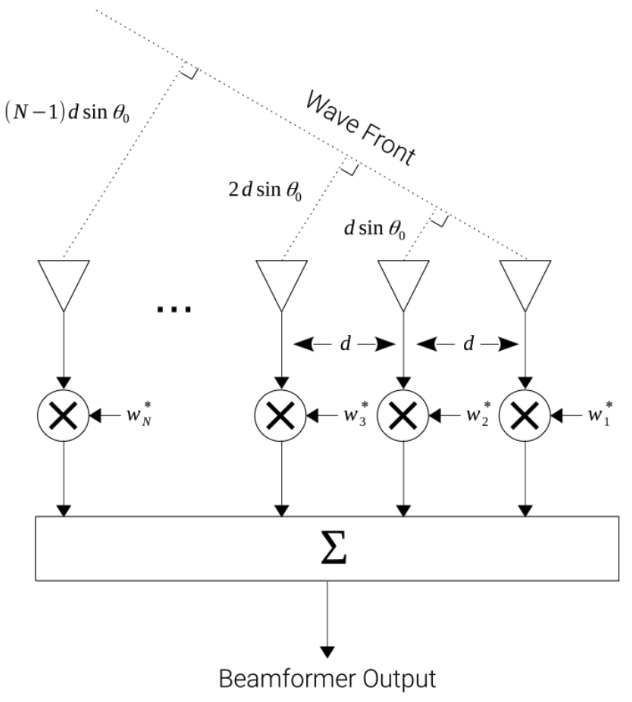

Set the parameters and system constants for the Uniform Linear Array (ULA), including the number of antenna elements, $N$, the operating/carrier frequency, $f_{c}$, and the desired plane wave _angle of arrival_ (AoA) relative to boresight, $\theta_{0}$:

In [ ]:
N       = 8     # number of elements in ULA
fc      = 300e6 # RF carrier frequency (assuming narrowband here)
fs      = 1e9   # IF/direct sampling frequency
theta   = -10   # desired signal Angle of Arrival (AoA) in degrees
SNR     = 1     # element SNR (linear units)
noiseP  = 1     # noise power (linear units)
spacing = 0.5   # d/wavelength element spacing (0.5 = half-wavelength spacing)

wavelength = fc/scipy.constants.c
# generate array of antenna element positions
antPos = np.linspace(0,N-1,N)*wavelength*spacing
plt.scatter(antPos, np.zeros(N), marker='1')
plt.title("ULA Element Positions, N=%i" % N)
plt.ylabel("Y-Position (m)")
plt.xlabel("X-Position (m)")
plt.show()

For narrowband signals, the complex spatial response vector is formed from the baseband envelope phasor at each ULA element, which is a function of AoA $\theta_{0}$, operating wavelength $\lambda$ , and the elemental spacing $d$:
$$ s_{n} = e^{j 2\pi (n-1) \frac{d}{\lambda} \sin{\theta_{0}} }  \quad 0 \leq n \leq N - 1 $$

In [ ]:
# given wavelength (same units as ula_pos_vec), azimuth direction of wave impinging on ULA, and N-element antenna position vector
def narrowband_spatial_phasor(wavelen, theta_deg, ula_pos_vec):
    cmplx_pos = (1j*2*np.pi/wavelen)*ula_pos_vec.T
    sn = np.exp(cmplx_pos*np.sin(np.deg2rad(theta_deg)))
    return sn
    
s = narrowband_spatial_phasor(wavelength, theta, antPos)

Compute hypothesis of steering vectors in sine space for quiescent beamforming weights. Plot the weight response over sine space by testing weight magnitude at each look direction in vector `u`, from $-90^{\circ}$ to $90^{\circ}$

In [ ]:
# numHyp = number of direction hypothesis to compute
def calc_quiescent_weights(wavelen, ula_pos_vec, numHyp=400):
    u = np.linspace(-1, 1, numHyp)
    wq = np.exp(np.outer((1j*2*np.pi/wavelen)*ula_pos_vec.T, u))
    # normalize quiescent filter weights to unity (0dB) @ boresight
    mag = wq * wq.conj()
    wq = wq / mag.sum(axis=0) # sum over columns (each channel, per hypothesis)
    return wq, u

wq, u = calc_quiescent_weights(wavelength, antPos, 400)

In [ ]:
def plot_az_cut(weights,                 # weights to plot
                thetas,                  # list of tuples (angles, wavelengths)
                                         # to plot (1st is desired angle)
                plt_title='Azimuth Cut', # plot title
                lims=[-40,1]):           # plot limits (b/c resp -> 0 near edges)
    # convolve quiescent ULA response w/given spatial weights
    conv_weights = np.inner(wq.conj().T, weights)
    fig, ax = plt.subplots()
    ax.plot(u*spacing, 20*np.log10(np.abs(conv_weights)), linewidth=0.5)
    ax.set(xlabel=r'Normalized Angle, $\frac{d}{\lambda} \sin(\theta)$',
           ylabel='Magnitude (dB)',
           title=plt_title)
    ax.set_ylim(lims)
    for idx, angle in enumerate(thetas):
        if idx == 0:
            lin_color = 'green'
            plt_lbl = r'$\theta_{c}$'
        elif idx == 1:
            lin_color = 'red'
            plt_lbl = r'$\theta_{Inf}$'
        else:
            lin_color = 'red'
            plt_lbl = ''
        # NOTE: since interference tone is at different frequency than desired
        #       tone, the normalized sine space plot scales the incidence angles
        #       by its wavelength
        norm_angle = np.sin(np.deg2rad(angle[0]))*spacing/angle[1]
        # wrap normalized angle for wavelengths >>/<< desired
        while norm_angle < -spacing:
            norm_angle += 2*spacing
        while norm_angle > spacing:
            norm_angle -= 2*spacing
        ax.vlines(norm_angle,
                  lims[0], lims[1],
                  colors=lin_color,
                  linestyles='dashed',
                  label=plt_lbl,
                  linewidth=(3 if idx == 0 else 1))
    ax.legend()
    plt.show()

# create matched filter (beam weights) for quiescent case (no interference)
plot_az_cut(s,
            [(theta, wavelength)],
            plt_title='Azimuth Cut: Quiescent Weight Response in Sine Space',
            lims=[-40, 1])

The equation in 2 dimensions, $u$ and $v$, becomes

$$ \Large F(\theta, \phi) = \sum_{m}^{M} \sum_{n}^{N} \lvert a_{m,n} \rvert \exp{\left\{ j k_0 \left[ m d_x (u - u_0) + n d_y (v - v_0) \right] \right\}} $$

or if $a_{m,n}$ is separable to $a_{m,n} = b_m c_n$, then

$$ \Large F(\theta, \phi) = \left\{ \sum b_m \exp{\left[ j k_0  m d_x \left( u - u_0 \right) \right]} \right\} \left\{ \sum c_n \exp{\left[ j k_0  n d_y \left( v - v_0 \right) \right]} \right\} $$

In [ ]:
N = 9  # number of elements in horizontal dimension
M = 9  # number of elements in vertical dimension

n = np.arange(N)  # array for summing over n
m = np.arange(M)  # array for summing over m

d_x = wavelength / 2  # x spacing
d_y = wavelength / 2  # y spacing
k_0 = 2 * np.pi / wavelength # wave number

steering_angle_theta = 10  # theta steering angle
steering_angle_phi = 30  # phi steering angle

u_0 = np.sin(steering_angle_theta * np.pi / 180)  # theta steering angle in sine space
v_0 = np.sin(steering_angle_phi * np.pi / 180)  # phi steering angle in sine space

npts = 100
theta = np.linspace(-np.pi, np.pi, npts)
phi = np.linspace(-np.pi, np.pi, npts)

u2 = np.sin(theta) * np.cos(phi)
v2 = np.sin(theta) * np.sin(phi)

u2 = np.linspace(-1, 1, npts)
v2 = np.linspace(-1, 1, npts)

U, V = np.meshgrid(u2, v2)  # mesh grid of sine space

In [ ]:
def compute_af_2d(weights_n, weights_m, d_x, d_y, k_0, u_0, v_0):
    AF_m = np.sum(
        weights_n[:, None, None]
        * np.exp(1j * n[:, None, None] * d_x * k_0 * (U - u_0)),
        axis=0,
    )
    AF_n = np.sum(
        weights_m[:, None, None]
        * np.exp(1j * m[:, None, None] * d_y * k_0 * (V - v_0)),
        axis=0,
    )

    AF = AF_m * AF_n / (M * N)
    return AF

In [ ]:
z_min = -25
z_max = 0

weights_n = np.ones(N)
weights_m = np.ones(M)
AF_rect = compute_af_2d(weights_n, weights_m, d_x,d_y,k_0,u_0,v_0)
AF_rect_log = 10 * np.log10(np.abs(AF_rect))
AF_rect_log_mask = np.where(AF_rect_log > z_min, AF_rect_log, np.nan)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(U, V, AF_rect_log_mask, cmap=cm.coolwarm)
ax.set_zlim(z_min, z_max)
ax.set_title("2D Antenna Pattern")
ax.set_xlabel("U")
ax.set_ylabel("V")
ax.set_zlabel("Magnitude (dB)")
ax.view_init(elev=30, azim=-50, roll=0)
ax.set_box_aspect(None, zoom=0.85)
plt.show()

### Array Effects

* [Phased Array Antenna Patterns—Part 1: Linear Array Beam Characteristics and Array Factor - Analog Devices](https://www.analog.com/en/analog-dialogue/articles/phased-array-antenna-patterns-part1.html#)
* [Phased Array Antenna Patterns—Part 2: Grating Lobes and Beam Squint - Analog Devices](https://www.analog.com/en/analog-dialogue/articles/phased-array-antenna-patterns-part2.html)
* [Phased Array Antenna Patterns—Part 3: Sidelobes and Tapering - Analog Devices](https://www.analog.com/en/analog-dialogue/articles/phased-array-antenna-patterns-part3.html)
* [RF Transceivers Enable Forced Spurious Decorrelation in Digital Beamforming Phased Arrays - Analog Devices](https://www.analog.com/en/technical-articles/rf-transceivers-enable-forced-spurious-decorrelation-in-digital-beamforming-phased-arrays.html)

#### Far-Field

The reason we assume far field characteristics for the majority of work with array systems is to simplify the math and operations; for the case of a phased array receiver in the near field, an RF emitter is so close to the array that the incident angle of the received energy is different for every element due to the spherical wavefront of the source:

<img src="https://www.analog.com/en/_/media/images/analog-dialogue/en/volume-54/number-2/articles/phased-array-antenna-patterns-part1/306159-fig-06.png" style="width: 40%; margin-left: auto; margin-right: auto">

However, in the far field, where the same emitter is farther away from the receiving array, the wavefronts become approximately planar, and each receive element sees an equivalent incidence angle, $\theta$, of the arriving wave:

<img src="https://www.analog.com/en/_/media/images/analog-dialogue/en/volume-54/number-2/articles/phased-array-antenna-patterns-part1/306159-fig-07.png" style="width: 40%; margin-left: auto; margin-right: auto">

The specific point at which a given system is operating in the far field is dependent on many factors of the array’s antenna properties, however a general equation can be found based on an array’s antenna diameter, $D$, and the wavelength of the operating carrier frequency, $\lambda$:

$$ Far Field > \frac{2D^{2}}{\lambda} $$

#### Grating Lobes

The spatial equivalent to the [Nyquist frequency in the temporal domain](https://en.wikipedia.org/wiki/Nyquist_frequency), to prevent spatial aliasing (_grating lobes_) the antenna element spacing should be $ \frac{d}{\lambda} \leq 0.5 $.

#### Array Calibration

In [ ]:
YouTubeVideo('ssuxQFzGJNU')

## Broadband Beamforming

* [Wideband Beamforming - MATLAB and Simulink](https://www.mathworks.com/help/phased/ug/wideband-beamforming.html)
* [Beamforming for Broadband Signals - Wireless Pi](https://wirelesspi.com/beamforming-for-broadband-signals/)
* [Beamforming Narrowband and Broadband Signals - Sonar Systems](https://www.intechopen.com/chapters/18871)
* [Subband Phase Shift Beamformer - MATLAB](https://www.mathworks.com/help/phased/ref/phased.subbandphaseshiftbeamformer-system-object.html#bs7mkit-1)
* [An Efficient Broadband Adaptive Beamformer without Presteering Delays](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7916022/)
* [Broadband Modal Coherence and Beamforming at Megameter Ranges](https://apps.dtic.mil/sti/pdfs/ADA384485.pdf)
* [MVDR broadband beamforming using polynomial matrix techniques](https://stax.strath.ac.uk/concern/theses/g445cd716)
* [Broadband Beamforming - UCSD](http://dsp.ucsd.edu/home/wp-content/uploads/ece251D_winter18/Broadband.pdf)

## Adaptive Beamforming

* [FPGA-Based Adaptive Digital Beamforming Using Machine Learning for MIMO Systems - JHU APL Masters Thesis](https://jscholarship.library.jhu.edu/items/3c738b67-18d4-4c35-8540-59e2487bfde9)
* [mathworks/FPGA-Adaptive-Beamforming-and-Radar-Examples: This repository contains FPGA/HDL demonstrations several beamforming and radar designs. Simulink models and MATLAB reference code are provided to showcase high-level simulation and HDL designs of various radar and array processing algorithms.](https://github.com/mathworks/FPGA-Adaptive-Beamforming-and-Radar-Examples)
* [Fixed-Point HDL-Optimized Minimum-Variance Distortionless-Response (MVDR) Beamformer - MATLAB &amp; Simulink](https://www.mathworks.com/help/phased/ug/fixed-point-hdl-optimized-mvdr-beamformer.html)

## Direction of Arrival (DOA) Estimation

### Monopulse Systems

* [Monopulse radar - Wikipedia](https://en.wikipedia.org/wiki/Monopulse_radar)
* [Monopulse Tracking with a Low Cost Pluto SDR - Jon Kraft - YouTube](https://www.youtube.com/watch?v=XP8OWMDHfOQ)

### Multiple Signal Classification (MUSIC)

* [MUltiple SIgnal Classification (MUSIC) Algorithm on AI Engine - AMD-Xilinx](https://github.com/Xilinx/Vitis-Tutorials/tree/2024.2/AI_Engine_Development/AIE/Design_Tutorials/18-MUSIC-Algorithm)

### DOA References

- _Introduction to Direction-of-Arrival Estimation_- Zhizhang Chen, Gopal Gokeda, Yiqiang Yu
- [KrakenRF Wiki/Docs](https://github.com/krakenrf/krakensdr_docs/wiki) for the [KrakenRF 5-Channel RX SDR](https://www.krakenrf.com/)
  + [krakenrf/krakensdr_doa - kraken_sdr_signal_processor.py](https://github.com/krakenrf/krakensdr_doa/blob/main/_sdr/_signal_processing/kraken_sdr_signal_processor.py)
  + [KrakenRF Forum](https://forum.krakenrf.com/)
- [gr-doa: Direction Finding in GNU-Radio](https://www.gnuradio.org/grcon/grcon17/presentations/gr_doa_gnuradio_direction_finding/Travis-Collins-gr-doa.pdf)
  + [MarcinWachowiak/gr-aoa](https://github.com/MarcinWachowiak/gr-aoa): GNU Radio package implementing MUSIC and root MUSIC angle of arrival algorithms with blocks necessary to provide phase synchronization of USRP devices
- [morriswmz/doatools.py - GitHub](https://github.com/morriswmz/doatools.py): provides basic tools for theoretical research on direction-of-arrival (DOA) estimation, including basic array designs, various DOA estimators, plus tools to compute performance bounds.

In [ ]:
YouTubeVideo('_UBPVi1vp2s')

## Distributed Beamforming/DoA

* [Distributed Beamforming Using 1-bit Feedback - MATLAB](https://www.mathworks.com/help/phased/ug/distributed-beamforming-using-1-bit-feedback.html)
* [Research on distributed beamforming synchronization technology in inter-satellite link system](https://journals.sagepub.com/doi/10.1177/00202940221089256)
* [Distributed Transmit Beamforming: Design and Demonstration from the Lab to UAVs](https://arxiv.org/abs/2110.13804)
* [Distributed Transmit Beamforming: Challenges and Recent Progress](https://www.researchgate.net/publication/224386337_Distributed_Transmit_Beamforming_Challenges_and_Recent_Progress)

In [ ]:
YouTubeVideo('lZqMBmPGQiY')

In [ ]:
YouTubeVideo('IsmCQs5KVCs')

## References

* [Beamforming and Direction Finding - MATLAB](https://www.mathworks.com/help/phased/beamforming-and-direction-finding.html)
* [jorgengrythe/beamforming: Matlab files for various types of beamforming](https://github.com/jorgengrythe/beamforming)
* _Introduction to Direction-of-Arrival Estimation_- Zhizhang Chen, Gopal Gokeda, Yiqiang Yu
* [MIMO Radar Antenna Arrays - Henrik's Blog](https://hforsten.com/mimo-radar-antenna-arrays.html)
* [petotamas/pyArgus](https://github.com/petotamas/pyArgus): Antenna array signal processing library implemented in python
* [zinka/arraytool](https://github.com/zinka/arraytool): Python based package for phased array antenna design and analysis
* [Phased Arrays - Steering and the Antenna Pattern Notebook](https://colab.research.google.com/drive/1kNJyeJEy4SPn0hMFzSHJUSyznxlfAh3n)

In [ ]:
YouTubeVideo('jSDLfcNhThw')

* [John Kraft (ADI) Beamforming Resources](https://github.com/jonkraft):
  + [DIY Phased Array YouTube Playlist](https://www.youtube.com/playlist?list=PLxC4LYGYcMqmnzAn_MBzCogL-feZ2ou4R)

In [ ]:
YouTubeVideo('0hnWfTvETcU')

In [ ]:
YouTubeVideo('XCe0xanaPFo')

In [ ]:
YouTubeVideo('nT7z6MxdEQE')